# EfficientNet

### Importando bibliotecas

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.callbacks import EarlyStopping

2025-11-19 19:33:33.846481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763580814.094488      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763580814.186246      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

### Definindo constantes

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 200
PATH = "/kaggle/input/pumch-isd/PUMCH-ISD"

### Conhecendo o conjunto de dados

In [5]:
image_paths = []
labels = []

class_names = sorted(os.listdir(PATH)) 
class_index = {name: idx for idx, name in enumerate(class_names)}

for disease_name in class_names:
    disease_path = os.path.join(PATH, disease_name)
    
    if os.path.isdir(disease_path):
        dermoscopy_path = os.path.join(disease_path, "dermoscopy")

        if os.path.exists(dermoscopy_path):
            for img_file in os.listdir(dermoscopy_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(dermoscopy_path, img_file)
                    image_paths.append(img_path)

                    labels.append(class_index[disease_name])

print(f"Doenças: {class_names}")
print(f"Qtde de imagens: {len(image_paths)}")

Doenças: ['Acne vulgaris', 'Dermatitis_subset1', 'Dermatitis_subset2', 'Lichen planus', 'Morphea', 'Pityriasis rosea', 'Psoriasis', 'Rosacea', 'Vitiligo']
Qtde de imagens: 7798


In [6]:
images = []
processed_labels = []
    
for i, (img_path, label) in enumerate(zip(image_paths, labels)):
    try:
        # Ler imagem colorida em 3 canais
        img = cv2.imread(img_path)
        if img is not None:
            # Converter BGR para RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
            # Redimensionar
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                
            # Normalizar para [0, 1]
            img = img.astype('float32') / 255.0
                
            images.append(img)
            processed_labels.append(label)
                
    except Exception as e:
        print(f"Erro ao processar {img_path}: {e}")

Corrupt JPEG data: 32760 extraneous bytes before marker 0xd9


In [7]:
X = np.array(images)
y = np.array(processed_labels)

X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [8]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 177, 1: 189, 2: 90, 3: 124, 4: 123, 5: 41, 6: 209, 7: 148, 8: 69}


### Definindo o modelo

In [9]:
NUM_CLASSES = len(class_names)

model = EfficientNetV2B0(
    include_top = False, 
    weights = "imagenet",
    input_tensor = None,
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    pooling = "avg",
    classes = len(class_names),
    classifier_activation = "softmax",
    include_preprocessing = True,
    name = "efficientnetv2-b0",
)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-11-19 19:41:18.596356: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,858,704 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [10]:
callback = EarlyStopping(
    monitor='val_loss',   
    patience=10,          
    restore_best_weights=True 
)

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[callback] 
)


Epoch 1/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 287s 1s/step - accuracy: 0.1588 - loss: 5.8759 - val_accuracy: 0.1855 - val_loss: 3.6557
Epoch 2/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - accuracy: 0.3810 - loss: 1.8987 - val_accuracy: 0.2607 - val_loss: 2.6118
Epoch 3/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.4340 - loss: 1.8133 - val_accuracy: 0.2598 - val_loss: 2.4524
Epoch 4/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.2647 - loss: 2.2342 - val_accuracy: 0.2111 - val_loss: 2.1256
Epoch 5/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.2513 - loss: 2.0301 - val_accuracy: 0.2923 - val_loss: 2.8966
Epoch 6/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.3604 - loss: 1.9018 - val_accuracy: 0.3350 - val_loss: 2.3016
Epoch 7/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.3674 - loss: 1.7879 - val_accuracy: 0.2427 - val_loss: 2.8747
Epoch 8/200
171/171 ━━━━━━━━━━━━━━━━━━━━ 237s 1s/step - accuracy: 0.3853 - loss: 1.7282 - 

### Conferindo o desempenho do modelo

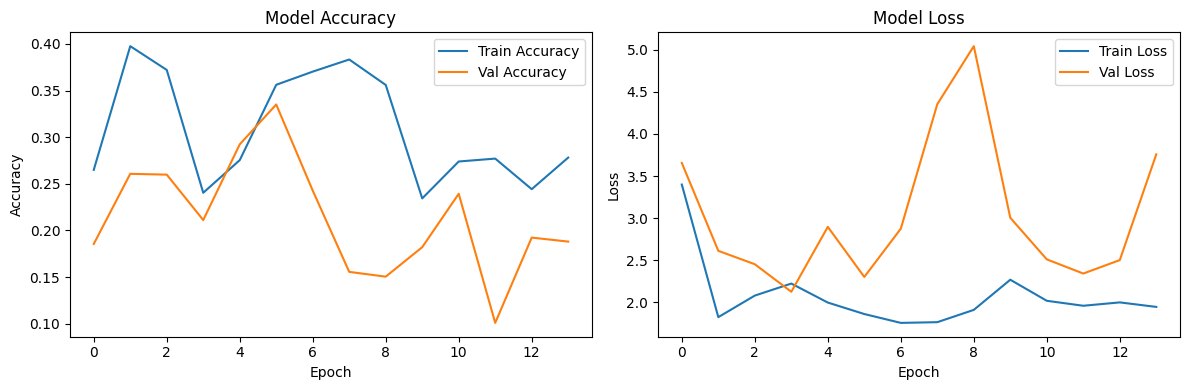

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
    
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
    
plt.tight_layout()
plt.show()

                    precision    recall  f1-score   support

     Acne vulgaris       0.18      0.34      0.23       177
Dermatitis_subset1       0.32      0.36      0.34       189
Dermatitis_subset2       0.13      0.66      0.21        90
     Lichen planus       0.35      0.16      0.22       124
           Morphea       0.26      0.05      0.08       123
  Pityriasis rosea       0.00      0.00      0.00        41
         Psoriasis       0.33      0.08      0.13       209
           Rosacea       0.44      0.05      0.10       148
          Vitiligo       1.00      0.01      0.03        69

          accuracy                           0.20      1170
         macro avg       0.34      0.19      0.15      1170
      weighted avg       0.33      0.20      0.18      1170



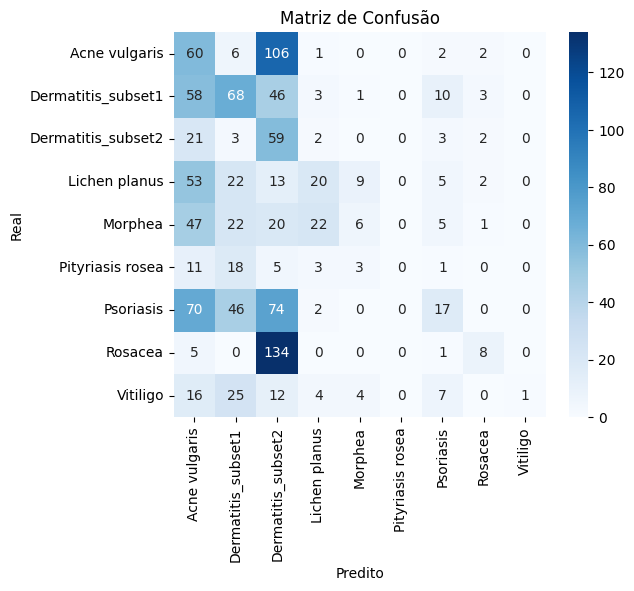

In [14]:
y_pred = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred, axis=1)  

cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, 
                            target_names=class_names, 
                            zero_division=0))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusão')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()